In [1]:
import pandas as pd
import urllib.request
import zipfile
import os
import json
import numpy as np
import skimage.io as io
import torch
import matplotlib.pyplot as plt

from pycocotools.coco import COCO
from pycocotools.mask import decode
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from pycocotools.mask import frPyObjects
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image

In [ ]:
# download COCO train set
url_train = "http://images.cocodataset.org/zips/train2017.zip"
urllib.request.urlretrieve(url_train, "train2017.zip")

# download COCO valid set
url_val = "http://images.cocodataset.org/zips/val2017.zip"
urllib.request.urlretrieve(url_val, "val2017.zip")

# download COCO annotation
url_annotations = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"
urllib.request.urlretrieve(url_annotations, "annotations_trainval2017.zip")

In [ ]:
# unzip the train set
with zipfile.ZipFile("train2017.zip", "r") as zip_ref:
    zip_ref.extractall("./")

# unzip the validation set
with zipfile.ZipFile("val2017.zip", "r") as zip_ref:
    zip_ref.extractall("./")

# unzip the annotation
with zipfile.ZipFile("annotations_trainval2017.zip", "r") as zip_ref:
    zip_ref.extractall("./")

In [2]:
class CocoPersonDataset(Dataset):
    def __init__(self, data_dir, data_type, transform = None):
        """
        Input:
        data_dir = "" # define dataset path
        data_type = "val2017"  # or "train2017"

        Variable:
        self.ann_file: the annotation path for train/validation
        self.coco: initialized COCO api
        self.person_cat_id: the class ID for person, here is 1
        self.person_img_ids: the Image ID list(Images with person), list

        Output:
        image: numpy array, (height, width, channel)
        segmentation: list of array, eg: [array1, array2]
        """
        self.data_dir = data_dir
        self.data_type = data_type

        # get information for train or validation set
        self.ann_file = os.path.join(data_dir, "annotations/instances_{}.json".format(data_type))

        # initialize COCO API
        self.coco = COCO(self.ann_file)

        # get the class ID for person
        self.person_cat_id = self.coco.getCatIds(catNms=["person"])

        # get the Image ID list for person
        self.person_img_ids = self.coco.getImgIds(catIds=self.person_cat_id)

        self.transfrom = transform

    def __len__(self):
        # the length of the dataset
        return len(self.person_img_ids)

    def __getitem__(self, idx):
        # load the image
        img_info = self.coco.loadImgs(self.person_img_ids[idx])[0]
        img_path = os.path.join(self.data_dir, self.data_type, img_info["file_name"])
        image = Image.open(img_path).convert('RGB')

        # get the annotation ID for all persons in this image, iscrowd = None is to make sure no overlap person
        ann_ids = self.coco.getAnnIds(imgIds=img_info["id"], catIds=self.person_cat_id, iscrowd=None)

        # get all annotation for all person in this image
        annotations = self.coco.loadAnns(ann_ids)

        # get mask list for human objs in the image
        masks = [self.coco.annToMask(ann) for ann in annotations]

        # transform image and mask to the same size
        if self.transfrom:
            image = self.transfrom(image)
            # channel, height, width
            image = image.numpy()
            # height, width, channel
            image = image.transpose(1, 2, 0)
            
            # for each obj mask, we make it PIL format and transform it as we do for image to the same size
            for m in range(len(masks)):
                masks[m] = Image.fromarray(masks[m])
                masks[m] = self.transfrom(masks[m]).numpy()
                masks[m] = masks[m].squeeze()

            # create a mask with all 0 that have the same size as image
            mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

            for m in masks:
            # add the each obj's mask to the mask
                mask = np.maximum(mask, m)

        return image, mask

In [3]:
transform = transforms.Compose([
                transforms.Resize((480, 640)),
                ToTensor(),
                # other transformations if needed
            ])

# get the validation data set
data_dir = ""
data_type = "val2017"  
validation_dataset = CocoPersonDataset(data_dir, data_type, transform=transform)

# get the train data set
data_type = "train2017"  
train_dataset = CocoPersonDataset(data_dir, data_type, transform=transform)

# show one of the validation picture
image, segmentations = validation_dataset[0]

print(f"The train dataset has {len(train_dataset)} images, The validation dataset has {len(validation_dataset)} images")

loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
loading annotations into memory...
Done (t=7.98s)
creating index...
index created!
The train dataset has 64115 images, The validation dataset has 2693 images


In [4]:
def segmentation_vitualize(image, mask):
    """
    image: np.array,
    segmentations: list[list]
    """
    # make a copy of the image
    masked_image = image.copy()

    # make the mask to be red
    masked_image[mask > 0] = (1, 0, 0)

    # plot the image
    plt.imshow(image)
    plt.imshow(masked_image)

    return None

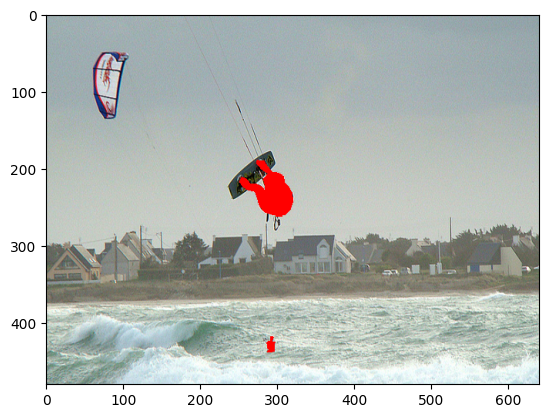

In [5]:
segmentation_vitualize(image, segmentations)

In [6]:
# define data loader
batch_size = 64

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True,
                         )



validation_loader = DataLoader(validation_dataset, 
                               batch_size=batch_size, 
                               shuffle=True,
                              )

In [ ]:
for batch_idx, data in enumerate(train_loader):
    print(data)
    break

In [8]:
# transform img 
def transform_PIL(image, segmentations):
    img = ((image*255).astype(np.uint8))
    img = Image.fromarray(img)
    size = img.size

    mask_img = np.zeros_like(image, dtype=np.uint8)
    mask_img[segmentations > 0] = (255, 255, 255)
    mask_img = Image.fromarray(mask_img)
    return img.resize((512,512)), mask_img.resize((512,512)), size

In [9]:
img, mask_img, size = transform_PIL(image, segmentations)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [18]:
# make a caption for the img
from transformers import pipeline

captioner = pipeline("image-to-text",model="ydshieh/vit-gpt2-coco-en")
caption = captioner(img)[0]['generated_text']
caption

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
e:\Python\lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
e:\Python\lib\site-packages\transformers\generation\utils.py:1288: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'a person para sailing on a beach with a kite '

In [19]:
from diffusers import StableDiffusionInpaintPipeline

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    revision="fp16",
    torch_dtype=torch.float16
)
pipe = pipe.to(device)

prompt = "remove the person from the image that have" + caption + " and only keep the background"

#image and mask_image should be PIL images.
#The mask structure is white for inpainting and black for keeping as is
implant_image = pipe(prompt=prompt, image=img, mask_image=mask_img).images[0]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
e:\Python\lib\site-packages\transformers\models\clip\feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


  0%|          | 0/50 [00:00<?, ?it/s]

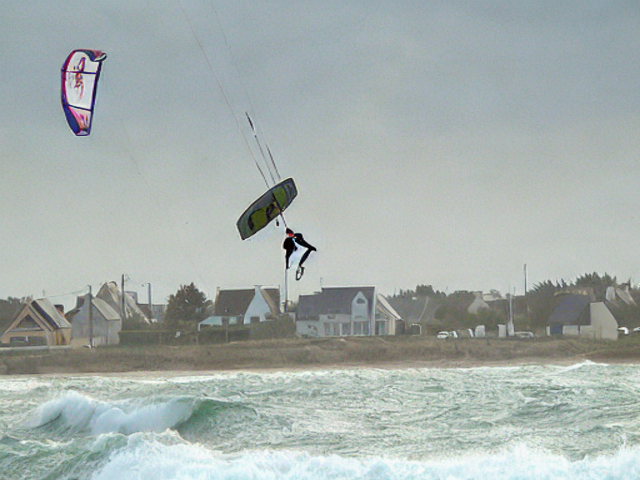

In [20]:
implant_image.resize(size)